In [1]:
import xarray as xr
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from sea_clearly import settings
from sea_clearly.create_masks import get_coastal_nodes

In [3]:
land_mask = xr.load_dataset('../data/CMEMS_MED_landmask.nc')
coast_mask = get_coastal_nodes(land_mask['mask_land']).astype(bool)

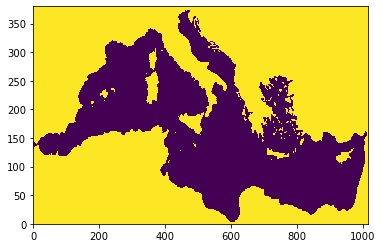

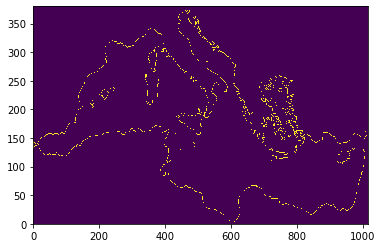

In [4]:
plt.pcolormesh(land_mask['mask_land'])
plt.figure()
plt.pcolormesh(coast_mask)

In [5]:
X,Y = np.meshgrid(land_mask['mask_land']['lon'],land_mask['mask_land']['lat'])
lons_coast = X[coast_mask]
lats_coast = Y[coast_mask]

In [12]:
from shapely.geometry import Point
all_medit_names = np.array(['Albania', 'Algeria', 'Bosnia and Herzegovina', 'Croatia',
       'Cyprus', 'Egypt', 'France', 'Greece', 'Israel', 'Italy',
       'Lebanon', 'Libya', 'Montenegro', 'Morocco', 'Northern Cyprus',
       'Palestine', 'Slovenia', 'Spain', 'Syria', 'Tunisia', 'Turkey'])


In [21]:
cstline_of=[]
countries_coast = np.nan*np.zeros(len(lons_coast))
for i1,(lon_,lat_) in enumerate(zip(lons_coast,lats_coast)):

        tmp_dist = np.inf
        shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
        reader = shpreader.Reader(shpfilename)
        countries = reader.records()
        for country in countries:
                geom = country.geometry
                country_name = str(country.attributes['NAME_LONG']).replace('\x00','')

                if country_name in all_medit_names:
                    
                    dist=geom.distance(Point(lon_,lat_))
                    if dist < tmp_dist:
                        i_country = np.where(all_medit_names == country_name)[0]
                        tmp_dist = dist
                        
        countries_coast[i1] = i_country
        
        if i1 % 100 == 0:
            print(i1)
            
gridded_countries = np.nan*np.zeros(land_mask['mask_land'].shape)
gridded_countries[coast_mask] = countries_coast



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


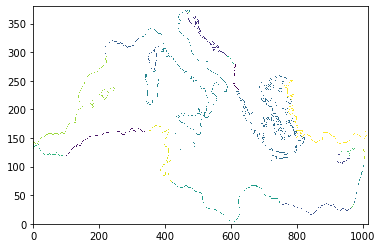

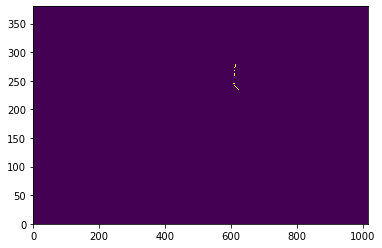

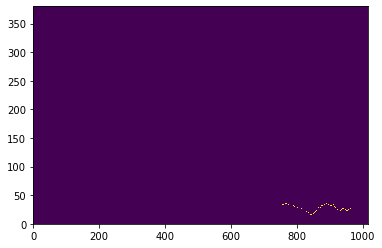

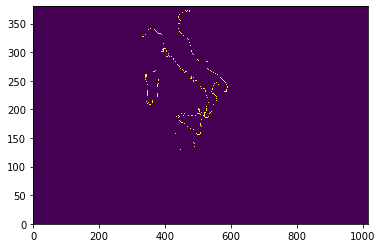

In [26]:
plt.figure()
plt.pcolormesh(gridded_countries)

# nr 0: Albania
plt.figure()
plt.pcolormesh(gridded_countries==0)

# nr 5: Egypt
plt.figure()
plt.pcolormesh(gridded_countries==5)

# nr 9: Italy
plt.figure()
plt.pcolormesh(gridded_countries==9)

In [27]:
# define coordinates
coords = {'lat': (['lat'], land_mask.lat.data),
         'lon': (['lon'], land_mask.lon.data)}

# define global attributes
attrs = {'mediterranean countries':all_medit_names, 
         'assigned numbers for corresponding country in coastal mask':np.arange(0,21)}

# create dataset
country_mask = xr.Dataset(coords=coords, 
                attrs=attrs)

country_mask['coast_country'] = (('lat', 'lon'), gridded_countries)

country_mask

<xarray.Dataset>
Dimensions:        (lat: 380, lon: 1016)
Coordinates:
  * lat            (lat) float32 30.19 30.23 30.27 30.31 ... 45.9 45.94 45.98
  * lon            (lon) float32 -6.0 -5.958 -5.917 -5.875 ... 36.21 36.25 36.29
Data variables:
    coast_country  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    mediterranean countries:                                     ['Albania' '...
    assigned numbers for corresponding country in coastal mask:  [ 0  1  2  3...

In [9]:
# this would be coastline_array array but I saved intermediately
# coastline_array=np.load('/rds/general/user/cej4917/home/seaclearly/Sea_Clearly/data/coastline_temp.npy')

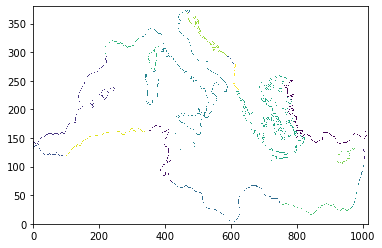

In [10]:
for i2,(lon_,lat_) in enumerate(zip(lons_coast, lats_coast)):
#     if i2<300:
        country_mask.coast_country.loc[dict(lon=lon_, lat=lat_)]=coastline_array[i2]
plt.figure()
plt.pcolormesh(country_mask['coast_country'])

In [28]:
country_mask.to_netcdf('../data/coastal_countries.nc')

In [30]:
# Here we can calculate the distance of a geom (country) to a point
# we can 1) loop through the coastline points.
# 2) for every Medit. country (see above) check the distance to the point
# 3) save the minimum distance and corresponding country
# 4) save the results in a netcdf. I suggest numbering the countries in the all_medit_names list (i.e. Albania=0, Algeria=1 etc.)
# and making a gridded file where the coastline points have a number corresponding to the list above
# you can use the function in sea_clearly/wrtie_tools to save as netcdf file
# 5) we should also define a lon/lat for each country where we plot the source 'circles'. This could probably also go in the netcdf file. These locations you can pick by hand


# in the end we want mask file (netcdf) with lon, lat, as coordinates 
# and mask_country with NaN if not coast, 
# and number(corresponding to med country) 
# replacing the original coastal mask 1's